# Exkurs: Training eines künstlichen neuronalen Netzes

### Hintergrund und Daten

Der hier verwendete Datensatz heißt MNIST und stammt von dieser Website: http://yann.lecun.com/exdb/mnist/.

Die Datei <b>mnist_data.npz</b> enthält die Matrizen $X\in\mathbb{R}^{60000\times 784}$, $Y\in\mathbb{R}^{60000\times 10}$, $X_t\in\mathbb{R}^{10000\times 784}$ und $Y_t\in\mathbb{R}^{10000\times 10}$. 

Die Matrizen $X$ und $Y$ enthalten den Datensatz, den Sie für die Optimierung verwenden sollen. In den Zeilen der Matrix $X$ stehen die Vektoren $x^i$. In den Zeilen von $Y$ sind die zugehörige Vektoren $y^i$ gespeichert. Dieser Datensatz besteht also aus $n=60000$ Datenpunkten.

Die Matrizen $X_t\in\mathbb{R}^{10000\times 784}$ und $Y_t\in\mathbb{R}^{10000\times 10}$ enthalten den Test-Datensatz. Es gilt ganz analog: In den Zeilen der Matrix $X_t$ stehen die Test-Vektoren $x^i_t$. In den Zeilen von $Y_t$ sind die zugehörige Vektoren $y^i_t$ gespeichert. Der Test-Datensatz besteht also aus $10000$ Datenpunkten.

Der Datensatz kann folgendermaßen geladen werden:

In [1]:
import numpy as np

data = np.load("mnist_data.npz")
X = data['X']
Y = data['Y']
X_t = data['X_t']
Y_t = data['Y_t']

Die mit den Vektoren $x^i$ kodierten Bilder können sehr einfach visualisiert werden. Wir schauen uns exemplarisch die 111. Zahl an:

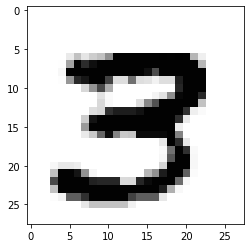

In [2]:
import matplotlib.pyplot
%matplotlib inline

i = 111
plot_array = X[i,:].reshape((28,28))
matplotlib.pyplot.imshow(plot_array, cmap='Greys', interpolation='None')

Im zugehörigen Vektor $y^i$ ist die Information gespeichert, dass es sich um die Ziffer 3 handelt.

In [3]:
Y[i,:]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

### Die Funktionen in MLP.py
In der Python-Datei <b>MLP.py</b> finden Sie die Python-Funktionen <b>F</b>, <b>F_gradient</b> und <b>h</b>, welche die Zielfunktion $F$, ihren Gradienten $\nabla F$ und die Prognosefunktion $h$ implementieren. (Sie müssen diese also nicht selbst implementieren.)

Damit Sie die Python-Funktionen in der Datei <b>MLP.py</b> in diesem Jupyter-Notebook verwenden können, werden die Inhalte der Datei importiert.

In [4]:
from MLP import *

Beachten Sie: Die Zielfunktion <b>F</b> wird für einen festen Trainingsdatensatz über die Parameter des neuronalen Netzes minimiert. Das heißt, in einem Lösungsverfahren werden <b>F</b> und <b>F-gradient</b> immer für verschiedene Parameter-Vektoren $w\in \mathbb{R}^d$ ausgewertet, der Trainingsdatensatz <b>X</b> und <b>Y</b> ist fest. 

Passen Sie daher die Aufrufstruktur mithilfe von lambda-Funktionen an.

In [5]:
F_val = lambda w: F(w,X,Y)
F_grad = lambda w: F_gradient(w,X,Y)

Die definierten lambda-Funktionen können an einem Parametervektor $w\in \mathbb{R}^d$ ausgewertet werden. Wir können hierbei feststellen, dass die Auswertung recht aufwändig ist.

In [6]:
d = 79510 # Anzahl der Parameter im Netzwerk
w_bar = 0.05 * np.random.randn(d) # Zufallsvektor 

In [7]:
import time

start = time.time()
F_val(w_bar)
print("Die Auswertung der Zielfunktion an w_bar benötigt {:.{prec}f} Sekunden".format(time.time()-start,prec=2))
start = time.time()
F_grad(w_bar)
print("Die Auswertung des Gradienten an w_bar benötigt {:.{prec}f} Sekunden".format(time.time()-start,prec=2))

Die Auswertung der Zielfunktion an w_bar benötigt 0.71 Sekunden
Die Auswertung des Gradienten an w_bar benötigt 1.03 Sekunden


### Optimierung mit Gradientenverfahren 

Implementieren Sie hier das Gradientenverfahren mit Armijo-Schrittweitensteuerung. 

Beachten Sie, dass in dieser Anwendung die Auswertung des Gradienten `F_grad` und der Zielfunktion `F_val` recht aufwändig ist. Passen Sie die Methoden daher so an, dass möglichst wenige Auswertungen benötigt werden.

Ergänzen Sie ein Zeitlimit, das dem Gradientenverfahren übergeben wird. Die Ausführung der while-Schleife wird beendet, wenn das Zeitlimit überschritten wird. Die Länge des Gradienten von F soll für den Abbruch des Verfahrens keine Rolle spielen.

In [8]:
import time

def gradientDescent_timelimit(obj_func, grad_func, line_search, x_0, T):
    """ classical gradient descent with timelimit
    """
    start_time = time.time()
    k = 0
    x = x_0 
    d = -grad_func(x)
    while (time.time()-start_time)<T: # Zeitlimit als Abbruchkriterium
        t = line_search(x,d) # Gradient wird nur ein mal pro while-Schleifen-Iteration berechnet, Armijo arbeitet nur mit d
        x = x+t*d
        d = -grad_func(x) 
        k += 1       
    x_crit = x
    f_crit = obj_func(x_crit)
    return x_crit, f_crit, k

def armijo_gd(x, d, obj_func, sigma, rho, gamma):
    """ Armijo stepsize for gradient descent
    """
    f_value = obj_func(x)
    t = gamma # hier fällt im Gradientenverfahren eine Berechnung weg
    x_trial = x+t*d
    f_trial = obj_func(x_trial)
    d_dot_d = d@d
    l = 0
    while (f_trial > f_value + t*sigma*(-d_dot_d)): # Es wird ausgenutzt, dass d dem negativen Gradienten an x entspricht
        t = rho*t
        x_trial = x+t*d
        f_trial = obj_func(x_trial)
        l += 1
    return t

### Startpunkte und Aufruf der Methode

Die Verfahren werden mit 5 (pseudo-)zufälligen Startpunkten $w^0$ gestartet.

In [9]:
runs = 5                                 
w_0 = np.zeros([runs,d])                 # "Platzhalter", Startvektoren Nr. i steht in der i-ten Zeile von w_0
np.random.seed(123)                      # Setzt den Seed des Zufallszahlengenerators auf 123
for k in range(runs):                   
    w_0[k,:] = 0.05 * np.random.randn(d) # Ein neuer "zufälliger" Startpunkt für jeden Durchlauf

Berechnen Sie für die Startpunkte eine Approximation eines kritischen Punktes der Funktion F mithilfe des zuvor beschriebenen Gradientenverfahrens. Für jeden Startpunkt soll das Verfahren 180 Sekunden laufen. Die Armijo-Parameter sind unten angegeben.

In [10]:
# Paramter Gradientenverfahren
Timelimit = 180
# Parameter Armijo-Regel
sigma = 0.2
rho = 0.5
gamma = 1

In [ ]:
# Lambda-Funktion zur Übergabe an der Armijo-Regel an das Gradientenverfahren
armijo_rule_gd = lambda x, d: armijo_gd(x, d, F_val, sigma, rho, gamma)

# Platzhalter Outputs
w_k = np.zeros([runs,d])
F_k = np.zeros(runs)
it_k = np.zeros(runs)

# Aufruf für jeden Startpunkt
for k in range(runs):
    w_k[k,:], F_k[k], it_k[k] = gradientDescent_timelimit(F_val, F_grad, armijo_rule_gd, w_0[k,:], Timelimit)

# Speichern des Ergebnisses
key_gdc = "sol_gdc_{0}_{1}"
np.savez(key_gdc.format(Timelimit,runs),w_k=w_k,F_k=F_k,it_k=it_k)

### Auswertung der Ergebnisse

Nun sollen Sie die Frage beantworten, wie viel Prozent der Bilder des Test-Datensatzes (<b>$X_t$, $Y_t$</b>) im Mittel korrekt erkannt werden, wenn die Prognosefunktionen verwendet werden, die sich aus den mit dem jeweiligen Verfahren berechneten Punkten ergeben. Was heißt in diesem Kontext "korrekt erkannt"? 

Ein Beispiel: Seien $x\in\mathbb{R}^{784}$ ein Punkt des Test-Datensatzes und $y$ das zugehörige Label. Dann sagen wir, dass das Bild $x$ bei Wahl des Punktes/Parameters $w\in\mathbb{R}^d$ (aus der vorigen Aufgabe!) korrekt erkannt wird, wenn der Index des größten Eintrags des Vektors $h(x;w)$ mit dem einzigen Nicht-Null-Eintrag von $y$ übereinstimmt, d.h. für $i\in\arg\!\max h(x;w)$ muss $y_i=1$ gelten.

Wenn Sie die Funktion $h$ mit

`Y_pred = h(w, X_t)`

aufrufen, enthält die Matrix <b>Y_pred</b> die Vorhersagen für jeden Punkt des Test-Datensatzes bei Wahl des Parameters <b>w</b>. Sie müssen diese Matrix dann wie oben beschrieben mit der gegebenen Matrix <b>Y_t</b> abgleichen, um herauszufinden, wie viel Prozent der Vorhersagen zutreffen. Dies wiederholen Sie dann für jeden der zuvor berechneten Parametervektoren. Geben Sie anschließend das arithmetische Mittel und die empirische Standardabweichung an.

In [11]:
# Daten aus Testlauf wieder laden
key_gdc = "sol_gdc_{0}_{1}"
data = np.load(key_gdc.format(Timelimit,runs)+".npz")
w_k = data['w_k']
F_k = data['F_k']
it_k = data['it_k']

In [12]:
# Ausgabe der Zielfunktionswerte der approximierten Punkte
print('Funktionswerte der Approximationen:')
print('------------------------------------')
print('Für jeden Startpunkt: ', F_k)   
print('deren Mittelwert: {:.{prec}f}'.format(np.mean(F_k),prec=3))
print('mit einer Standartabweichung von: {:.{prec}f}'.format(np.std(F_k), prec=3))

Funktionswerte der Approximationen:
------------------------------------
Für jeden Startpunkt:  [0.7514268  1.06899841 0.83076993 0.88347581 0.80724273]
deren Mittelwert: 0.868
mit einer Standartabweichung von: 0.109


In [13]:
# Berechnung der Prognosegenauigkeit
accuracy = np.zeros(runs)
for k in range(runs):
    Y_pred = h(w_k[k,:],X_t)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = np.argmax(Y_t, axis=1)
    accuracy[k] = np.sum(y_pred==y_true)/y_pred.size 
    
print('Richtigkeit der Vorhersagen:')
print(accuracy)
print('------------------------------------------------')
print('Die {} Prognosefunktionen haben eine durchschnittliche Richtigkeit von {:.{prec}f} % auf dem Testdatensatz'.format(runs, np.mean(accuracy)*100, prec=2))
print('Die Standartabweichung der Vorhersagen beträgt {:.{prec}f} %'.format(np.std(accuracy)*100, prec=3))

Richtigkeit der Vorhersagen:
[0.8414 0.7709 0.8315 0.821  0.8363]
------------------------------------------------
Die 5 Prognosefunktionen haben eine durchschnittliche Richtigkeit von 82.02 % auf dem Testdatensatz
Die Standartabweichung der Vorhersagen beträgt 2.556 %


## Konjugierte Gradientenverfahren von Fletcher-Reeves

Implementieren Sie nun das CG-Verfahren von Fletcher Reeves mit Armijo-Schrittweitensteuerung. 

Das Verfahren soll ebenfalls nach einem gesetzten Zeitlimit abbrechen. Achten Sie wieder darauf nur so viele Auswertungen des Gradienten und der Zielfumktion wie nötig zu berechnen.

In [14]:
def CG_FR_timelimit(obj_func, grad_func, line_search, x_0, T):
    """ nonlinear conjugate gradient method of Fletcher-Reeves
    """
    start_time = time.time()
    k = 0
    x = x_0
    gradient = grad_func(x)
    norm_grad = np.linalg.norm(gradient)
    d = -gradient
    while (time.time() - start_stime) < T:
        t = line_search(x, d, gradient)
        x = x + t * d
        norm_grad_old = norm_grad
        gradient = grad_func(x)
        norm_grad = np.linalg.norm(gradient)
        d = -gradient + (norm_grad**2 / norm_grad_old**2) * d
        k += 1
    x_opt = x
    f_opt = obj_func(x_opt)
    return x_opt, f_opt, k

def armijo(x, d, gradient_at_x, obj_func, sigma, rho, gamma):
    """ Armijo stepsize
    """
    f_value = obj_func(x)
    gx_dot_d = gradient_at_x@d
    t = -gamma*(gx_dot_d)/(d@d)
    x_trial = x+t*d
    f_trial = obj_func(x_trial)
    l = 0
    while (f_trial > f_value + t*sigma*(gx_dot_d)):
        t = rho*t
        x_trial = x+t*d
        f_trial = obj_func(x_trial)
        l += 1    
    return t

Führen Sie für das CG-Verfahren nun die gleichen Schritte aus, wie für das Gradientenverfahren und vergleichen Sie die Ergebnisse. Die Parameter sind nachfolgend angegeben.

In [15]:
# Parameter CG
Timelimit = 180
# Paramter Armijo
sigma = 0.2
rho = 0.5
gamma = 50

In [ ]:
# Lambda-Funktion zur Übergabe an der Armijo-Regel an das CG-Verfahren
armijo_cg = lambda x, d, gradient_at_x: armijo(x, d, gradient_at_x, F_val, sigma, rho, gamma)

# Platzhalter für die Outputs
w_k = np.zeros([runs,d])
F_k = np.zeros(runs)
it_k = np.zeros(runs)

# Aufruf für jeden Startpunkt
for k in range(runs):
    w_k[k,:], F_k[k], it_k[k] = CG_FR_timelimit(F_val, F_grad, armijo_cg, w_0[k,:], Timelimit)

# Speichern des Ergebnisses
key_cg = "sol_cg_{0}_{1}"
np.savez(key_cg.format(Timelimit,runs), w_k=w_k, F_k=F_k, it_k=it_k)

In [16]:
# Daten aus Testlauf wieder laden
key_cg = "sol_cg_{0}_{1}"
data = np.load(key_cg.format(Timelimit,runs)+".npz")
w_k = data['w_k']
F_k = data['F_k']
it_k = data['it_k']

In [17]:
# Ausgabe der Zielfunktionswerte der approximierten Punkte
print('Funktionswerte der Approximationen:')
print('------------------------------------')
print('Für jeden Startpunkt: ', F_k)   
print('deren Mittelwert: {:.{prec}f}'.format(np.mean(F_k),prec=3))
print('mit einer Standartabweichung von: {:.{prec}f}'.format(np.std(F_k), prec=3))

Funktionswerte der Approximationen:
------------------------------------
Für jeden Startpunkt:  [0.13052453 0.13590667 0.13278504 0.16679742 0.13911266]
deren Mittelwert: 0.141
mit einer Standartabweichung von: 0.013


In [18]:
# Berechnung der Prognosegenauigkeit 
accuracy = np.zeros(runs)
for k in range(runs):
    Y_pred = h(w_k[k,:],X_t)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = np.argmax(Y_t, axis=1)
    accuracy[k] = np.sum(y_pred==y_true)/y_pred.size 
    
print('Richtigkeit der Vorhersagen:')
print(accuracy)
print('------------------------------------------------')
print('Die {} Prognosefunktionen haben eine durchschnittliche Richtigkeit von {:.{prec}f} % auf dem Testdatensatz'.format(runs, np.mean(accuracy)*100, prec=2))
print('Die Standartabweichung der Vorhersagen beträgt {:.{prec}f} %'.format(np.std(accuracy)*100, prec=3))

Richtigkeit der Vorhersagen:
[0.9548 0.9538 0.9548 0.9489 0.9544]
------------------------------------------------
Die 5 Prognosefunktionen haben eine durchschnittliche Richtigkeit von 95.33 % auf dem Testdatensatz
Die Standartabweichung der Vorhersagen beträgt 0.225 %
